In [13]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from classes.music import MUSIC

warnings.simplefilter('ignore')

In [14]:
antenna_poplulation = 8
y_distance = 2
tags_angle = np.array([-30])
tags_location = np.tan(tags_angle * np.pi / 180) * y_distance 
tag_population = tags_location.shape[0]
tag_numbers = [i + 1 for i in range(tag_population)]
sample_count = 1000
frequency = 920.4e6
transmission_power = 37.5
light_speed = 2.998e8
wave_length = light_speed / frequency
print(f"wave_length = {wave_length}")
antenna_space = 0.04
print(f"maximum antenna_space = {wave_length / 4}")
angular_velocity = 2 * np.pi * frequency
theta_range = np.arange(-90, 90.001, 0.001)
max_range = y_distance * np.tan(np.radians(68) / 2)
print(f"max_range = {max_range}")
antenna_gain_dbi = 5.0
tx_power = 30.0
antenna_gain_watt = 10 ** ((antenna_gain_dbi - 30) / 10)

wave_length = 0.3257279443720122
maximum antenna_space = 0.08143198609300305
max_range = 1.3490170336848535


### Generate Sample data

In [15]:
"""
In mock data, the phase data seem to be corrected by the wave which transmited first
in each period for making it easier to analysis.
-> s(t) can be constant value of transmission_power
"""

# tag_location[m] is distance between tag and y-axis
tag_angles = np.arctan(tags_location / y_distance)

print(tag_angles * 180 / np.pi)

phase_samples = [np.array(
    [
        -(
            4 * np.pi * (y_distance / np.abs(np.cos(tag_angles)) - (antenna - 1) * antenna_space * np.sin(tag_angles)) / wave_length
            + np.random.normal(loc=0, scale=1 / 12, size=tag_population)
            + np.random.randint(0, 2, size=tag_population) * np.pi
        )
        % (2 * np.pi)
        for antenna in range(1, antenna_poplulation + 1)
    ]
).T for i in range(sample_count)]

columns = ["samplingNumber", "tagNumber", "frequency"]
phase_columns = [f"tag{i+1}.phase" for i in range(antenna_poplulation)]
columns.extend(phase_columns)

df = pd.DataFrame(columns=columns)

for i in range(sample_count):
    new_data = pd.DataFrame(data=phase_samples[i])
    new_data["samplingNumber"] = i
    new_data["tagNumber"] = [i+1 for i in range(tag_population)]
    new_data["frequency"] = frequency
    for antenna in range(antenna_poplulation):
        new_data = new_data.rename(columns={antenna: f"tag{antenna+1}.phase"})
    df = pd.concat([df, new_data])

transmit_wave = np.full(
    (sample_count, antenna_poplulation, tag_population), transmission_power
)

df.head(6)

[-30.]


,samplingNumber,tagNumber,frequency,tag1.phase,tag2.phase,tag3.phase,tag4.phase,tag5.phase,tag6.phase,tag7.phase,tag8.phase
0,0,1,920400000.0,4.889388,4.454590,0.699182,5.899429,5.212087,1.135865,0.363627,6.105325
0,1,1,920400000.0,2.042559,1.219012,0.659715,2.838661,5.162889,4.485294,3.694755,5.954062
0,2,1,920400000.0,5.137780,1.309084,3.804231,2.927924,1.901036,4.361798,3.695969,6.046545
0,3,1,920400000.0,2.111371,4.345335,3.658686,2.843540,5.084925,4.445681,3.508665,2.743630
0,4,1,920400000.0,1.977297,4.446292,3.469773,2.856575,2.016186,1.441475,0.601188,2.843659
0,5,1,920400000.0,5.030672,1.242678,0.565060,2.823140,2.228420,4.421263,3.718664,6.085249


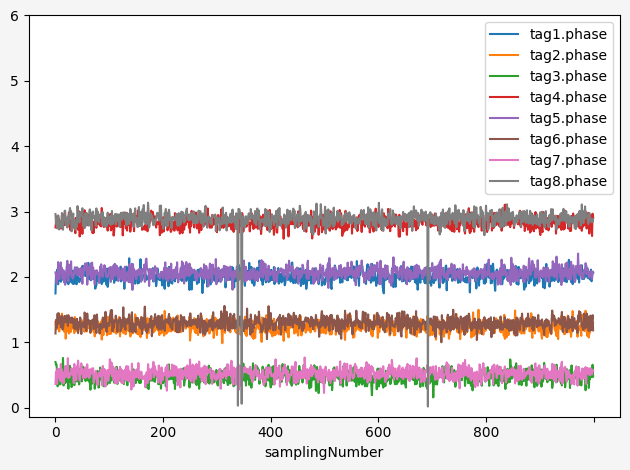

In [16]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
for antenna in range(1, antenna_poplulation+1):
    df[f"tag{antenna}.phase"] = df[f"tag{antenna}.phase"] % (np.pi)
    df.plot(ax=ax, x="samplingNumber", y=f"tag{antenna}.phase")
ax.set_yticks(np.arange(0, 7, 1))
plt.show()

In [17]:
df = df.query(f"tagNumber in {tag_numbers}")
data_list = np.empty((0, tag_population, antenna_poplulation))

data_list = np.array(
    [
        df.query(f"samplingNumber == {sampling_number}")
        .sort_values("tagNumber")[phase_columns]
        .to_numpy()
        for sampling_number in range(sample_count)    ]
)

## MUSIC Method

In [18]:
music = MUSIC(
    antenna_poplulation=antenna_poplulation,
    tag_population=tag_population,
    sampling_count=sample_count,
    antenna_space=antenna_space,
    theta_range=theta_range,
    frequency=frequency
)

music_spectrum = music.get_music_spectrum(
    phase_data_list=data_list,
)
estimated_angles = music.peak_search(music_spectrum=music_spectrum)
print(estimated_angles)

[-29.936]


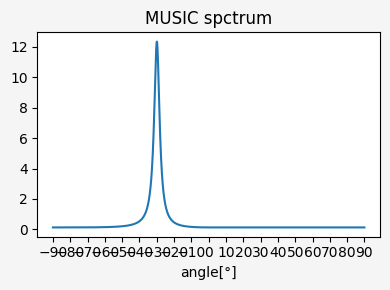

In [19]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=4, h=3)
x = theta_range
ax.plot(x, music_spectrum)
ax.set_xticks(np.arange(-90, 91, step=10))
ax.set_title("MUSIC spctrum")
ax.set_xlabel("angle[°]")
plt.show()

In [20]:
# error_list = []
# sample_count = 1
# tag_angles = np.array([-30])

# for y_distance in np.arange(0, 7, 0.1):
#     phase_samples = [np.array(
#         [
#             -(
#                 4 * np.pi * (y_distance / np.abs(np.cos(tag_angles * np.pi / 180)) - (antenna - 1) * antenna_space * np.sin(tag_angles * np.pi / 180)) / wave_length
#             )
#             % (2 * np.pi)
#             for antenna in range(1, antenna_poplulation + 1)
#         ]
#     ).T for i in range(1)]
#     phase_samples = np.array(phase_samples)

#     music_spectrum = music.get_music_spectrum(
#         phase_data_list=phase_samples
#     )

#     error = abs(music.peak_search(music_spectrum=music_spectrum)[0] - tag_angles[0])
#     print(error)
#     error_list.append(error)

# fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
# fig.set_size_inches(w=5, h=4)
# ax.plot(np.arange(0, 7, 0.1), error_list)
# ax.set_xlabel("y-axis distance[m]")
# ax.set_ylabel("error[degree]")
# plt.show()

## Near-field Localization

In [21]:
antenna_location = []
antenna_space = 0.25
y_distance = 2
for l in range(antenna_poplulation):
    antenna_location.append(l*antenna_space)
antenna_location = np.array(antenna_location)

tag_coordinate = {
    "x": tags_location[0],
    "y": y_distance
}

R = np.array([np.sqrt((tag_coordinate["x"]-antenna_location[m])**2 + tag_coordinate["y"]**2) for m in range(antenna_poplulation)])
phase = 4*np.pi*R / wave_length
N, phase = np.divmod(phase, 2*np.pi)

print((N, phase))

(array([14., 15., 15., 16., 18., 19., 20., 21.]), array([1.13058568, 0.04051432, 5.89541476, 6.01987794, 0.32025824,
       1.28457258, 2.56509207, 4.10909093]))


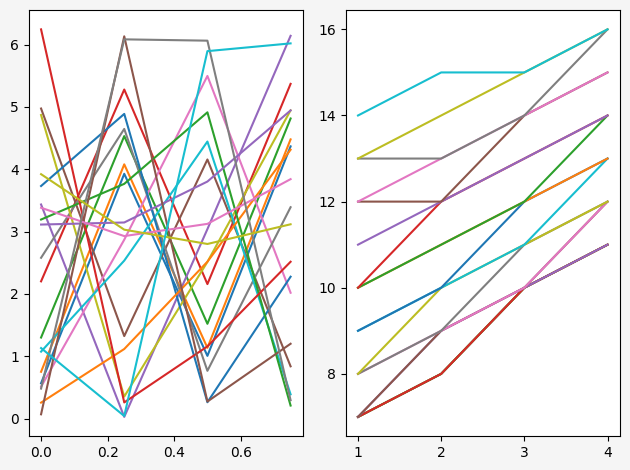

In [54]:
antenna_space = 0.25
antenna_poplulation=4
fig,axes = plt.subplots(1, 2, tight_layout=True, facecolor="whitesmoke")
for y_distance in np.linspace(0, 2, 20):
    antenna_location = []
    for l in range(antenna_poplulation):
        antenna_location.append(l*antenna_space)
    antenna_location = np.array(antenna_location)
    tag_coordinate = {
        "x": tags_location[0],
        "y": y_distance
    }
    R = np.array([np.sqrt((tag_coordinate["x"]-antenna_location[m])**2 + tag_coordinate["y"]**2) for m in range(antenna_poplulation)])
    phase = 4*np.pi*R / wave_length
    N, phase = np.divmod(phase, 2*np.pi)
    # N = N - N.min()
    tag_distance = np.sqrt(tag_coordinate["x"]**2 + tag_coordinate["y"]**2)
    axes[0].plot(antenna_location, phase)
    axes[1].plot(np.arange(1, antenna_poplulation+1), N)